In [1]:
import sys
import glob
import os
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
def parse_filename(filename):
    fn_re = "pool-(?P<pool>.+)_expr-(?P<expr>.+)_sw-(?P<sw>\d+)"
    fn_re = fn_re + "_es-(?P<es>\d+)_qd-(?P<qd>\d+)_pg-(?P<pg>\d+)"
    fn_re = fn_re + "_rt-(?P<rt>\d+)_if-(?P<if>.+)_cv.*\.log"
    fn_re = re.compile(fn_re)
    match = fn_re.match(os.path.basename(filename))
    assert match
    return match

In [3]:
def short_ename(ename):
    mapping = {
        'bytestream_n1_write': 'n1wr',
        'bytestream_n1_append': 'n1ap',
        'bytestream_11': '11wr',
        'map_n1': 'n1kv',
        'map_11': '11kv'
    }
    return mapping[ename]

def short_iface(iface):
    mapping = {
        'cls_full': 'cls_full_omap',
        'cls_full_hdr_idx': 'cls_full_hdr',
        'vanilla': 'librados',
        'cls_check_epoch': 'cls_app_chk_epc_omap',
        'cls_no_index_wronly': 'cls_null_app_wronly',
        'cls_check_epoch_hdr': 'cls_app_chk_epc_hdr'
    }
    return mapping[iface]

In [4]:
def read_trace(filename, trimFrontSec=30, trimBackSec=30):
    ### read up raw throughput file
    trace = pd.read_table(filename, sep=" ",
        header=None, names=("completed", "throughput"))
    
    ### shift timeseries to have zero start time
    trace.completed = pd.to_datetime(trace.completed, unit="ns")
    trace.completed = trace.completed - min(trace.completed)
    trace.completed = trace.completed / pd.Timedelta(seconds=1)
    
    ### trim front and back of trace
    trace = trace[(trace.completed > trimFrontSec) & (trace.completed <
        max(trace.completed) - trimBackSec)]
    trace.completed = trace.completed - min(trace.completed)
    
    ### order like a time series by the completion time of the I/O
    trace.sort_values(by='completed', ascending=True, inplace=True)
    return trace

In [5]:
def plot_throughput_trace(trace, md, ax):
    trace.throughput = pd.rolling_mean(trace.throughput, window=5, min_periods=1)
    ename = short_ename(md.group('expr'))
    iface = short_iface(md.group('if'))
    label = ename + '+' + iface
    ax.plot(trace.completed, trace.throughput, label=label)
    #ax.set_title('Single OSD Throughput (Jewel 2016)')
    ax.set_ylabel('Appends per Second per OSD')
    ax.set_xlabel('Time (Sec)')

In [6]:
def plot_traces(traces, fn, finish=True):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for filename in traces:
        trace_data = read_trace(filename)
        md = parse_filename(filename)
        print os.path.basename(filename), 'mean', trace_data.throughput.mean()
        plot_throughput_trace(trace_data, md, ax)
    if finish:
        lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig(fn + '.png', dpi=300, bbox_inches='tight', bbox_extra_artists=(lgd,))
    else:
        return ax

pool-zlog_expr-bytestream_n1_append_sw-128_es-1024_qd-16_pg-128_rt-120_if-cls_full_cv-10.2.0_cs-3a9fba20.tp.log mean 10612.9166667
pool-zlog_expr-bytestream_n1_append_sw-128_es-1024_qd-16_pg-128_rt-120_if-cls_full_hdr_idx_cv-10.2.0_cs-3a9fba20.tp.log mean 15836.5833333
pool-zlog_expr-bytestream_n1_append_sw-128_es-1024_qd-16_pg-128_rt-120_if-vanilla_cv-10.2.0_cs-3a9fba20.tp.log mean 18454.9166667
pool-zlog_expr-bytestream_n1_append_sw-128_es-1024_qd-16_pg-128_rt-120_if-cls_check_epoch_cv-10.2.0_cs-3a9fba20.tp.log mean 14056.75
pool-zlog_expr-bytestream_n1_append_sw-128_es-1024_qd-16_pg-128_rt-120_if-cls_no_index_wronly_cv-10.2.0_cs-3a9fba20.tp.log mean 16350.5
pool-zlog_expr-bytestream_n1_append_sw-128_es-1024_qd-16_pg-128_rt-120_if-cls_check_epoch_hdr_cv-10.2.0_cs-3a9fba20.tp.log mean 16013.5833333


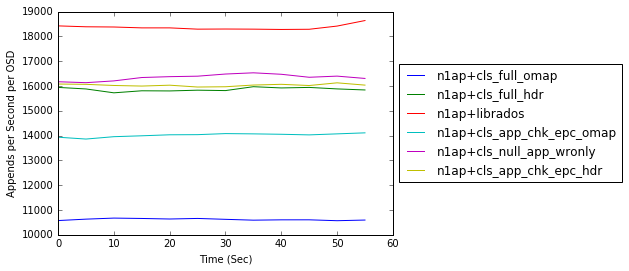

In [7]:
traces = glob.glob('results.pd.basic_cls_overhead.node0.04-21-2016_23-00-29.smoke.test/*.log')
plot_traces(list(traces), 'output.pool.reset')

pool-zlog_expr-bytestream_n1_append_sw-128_es-1024_qd-32_pg-128_rt-3600_if-cls_no_index_wronly_cv-10.2.0_cs-3a9fba20.tp.log mean 18942.8757062
pool-zlog_expr-bytestream_n1_append_sw-128_es-1024_qd-32_pg-128_rt-3600_if-cls_check_epoch_cv-10.2.0_cs-3a9fba20.tp.log mean 17014.0550847
pool-zlog_expr-bytestream_n1_append_sw-128_es-1024_qd-32_pg-128_rt-3600_if-cls_full_hdr_idx_cv-10.2.0_cs-3a9fba20.tp.log mean 18478.6144068
pool-zlog_expr-bytestream_n1_append_sw-128_es-1024_qd-32_pg-128_rt-3600_if-vanilla_cv-10.2.0_cs-3a9fba20.tp.log mean 22346.3644068
pool-zlog_expr-bytestream_n1_append_sw-128_es-1024_qd-32_pg-128_rt-3600_if-cls_full_cv-10.2.0_cs-3a9fba20.tp.log mean 12931.0
pool-zlog_expr-bytestream_n1_append_sw-128_es-4096_qd-32_pg-128_rt-3600_if-cls_no_index_wronly_cv-10.2.0_cs-3a9fba20.tp.log mean 16072.8629944
pool-zlog_expr-bytestream_n1_append_sw-128_es-4096_qd-32_pg-128_rt-3600_if-vanilla_cv-10.2.0_cs-3a9fba20.tp.log mean 17598.6567797
pool-zlog_expr-bytestream_n1_append_sw-128_es-4

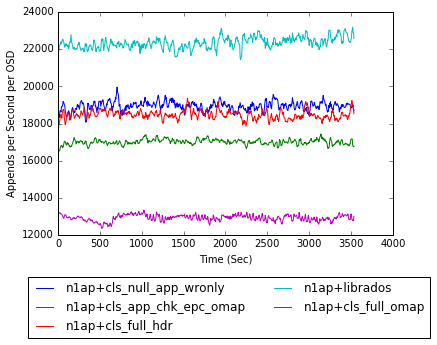

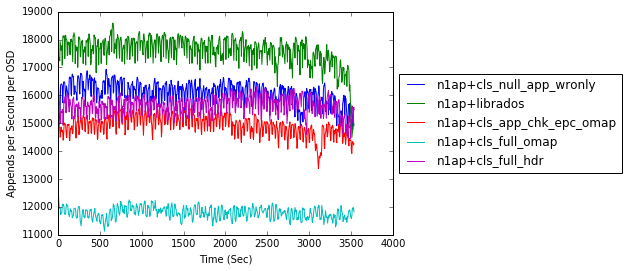

In [8]:
traces_es1024 = glob.glob('results.pd.basic_cls_overhead.node0.04-22-2016_00-48-56/*_es-1024_*.log')
ax = plot_traces(list(traces_es1024), 'output.pool.reset', finish=False)
lgd = ax.legend(loc='best', ncol=2, bbox_to_anchor=(1.0,0.0), bbox_transform=plt.gcf().transFigure)
plt.savefig('output.1024.soft.reset.png', dpi=300, bbox_inches='tight')

traces_es4096 = glob.glob('results.pd.basic_cls_overhead.node0.04-22-2016_00-48-56/*_es-4096_*.log')
plot_traces(list(traces_es4096), 'output.pool.reset')

In [9]:
# pool-zlog_expr-bytestream_n1_append_sw-128_es-1024_qd-32_pg-128_rt-3600_if-vanilla_cv-10.2.0_cs-3a9fba20.tp.log mean 22346.3644068
# pool-zlog_expr-bytestream_n1_append_sw-128_es-1024_qd-32_pg-128_rt-3600_if-cls_no_index_wronly_cv-10.2.0_cs-3a9fba20.tp.log mean 18942.8757062
# pool-zlog_expr-bytestream_n1_append_sw-128_es-1024_qd-32_pg-128_rt-3600_if-cls_full_hdr_idx_cv-10.2.0_cs-3a9fba20.tp.log mean 18478.6144068
print 18942.8 / 22346.3
print 18478.6 / 18942.8

0.847692906656
0.975494647043


In [10]:
# pool-zlog_expr-bytestream_n1_append_sw-128_es-4096_qd-32_pg-128_rt-3600_if-vanilla_cv-10.2.0_cs-3a9fba20.tp.log mean 17598.6567797
# pool-zlog_expr-bytestream_n1_append_sw-128_es-4096_qd-32_pg-128_rt-3600_if-cls_no_index_wronly_cv-10.2.0_cs-3a9fba20.tp.log mean 16072.8629944
# pool-zlog_expr-bytestream_n1_append_sw-128_es-4096_qd-32_pg-128_rt-3600_if-cls_full_hdr_idx_cv-10.2.0_cs-3a9fba20.tp.log mean 15655.2669492
print 16072.8 / 17598.6
print 15655.2 / 16072.8

0.913299921585
0.974018217112
